## Paper replication test
This notebook attemps to replicate the method from 2016:
Surangsrirat, Decho, et al. "Support vector machine classification of Parkinson's disease and essential tremor subjects based on temporal fluctuation." 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC). IEEE, 2016.

We use the features proposed in the paper, and a classificator coming from this paper.
We use the pre-processing pipeline establised previsouly, which corresponds to our EMG data.

In [1]:
# requirements
import os
import sys
sys.path.insert(0,'..') # to add parent directory
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from utils.data_loader import PatientsRawData
from utils.preprocessing import preprocess_signal
from utils.augment_data import get_augmentation_indexes, augment_data
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score


### load data

In [2]:
data = PatientsRawData('../../data/Исходные файлы/')
data.load_data()
print(f' Data labels: {data.Y} for the total of {len(data.X)} data samples coming from patients: {data.patient}')
print('Explore a random data sample: ')
N = random.randint(0,len(data.X))
data.X[N].head()
data.get_emg_data()

 Data labels: ['Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right'] for the total of 41 data samples coming from patients: ['аста0101.txt', 'дюки0102.txt', 'керш0103.txt', 'лега0104.txt', 'сидо0105.txt', 'фрол0106.txt', 'хвал0107.txt', 'черк0108.txt', 'даке0101.txt', 'ершо0102.txt', 'кудр0103.txt', 'купр0104.txt', 'куту0105.txt', 'лити0106.txt', 'луче0107.txt', 'макс0108.txt', 'миро0109.txt', 'молю01010.txt', 'муха01011.txt', 'соко01012.txt', 'тихо01013.txt', 'ерми0101.txt', 'кова0102.txt', 'колг0103.txt', 'медв0104.txt', 'наза0105.txt', 'погр0106.txt', 'савв0107.txt', 'сави0108.txt', 'шелу0109.txt', 'бело0101.txt', 'гава0102.txt', 'голу0103.txt', 'грек0104.txt', 'губа0105.txt', 'павл0106.txt', 'пана0107.tx

### pre-process  data
We use the same pre-processing as previously, but this time without applying the Hilber function.

In [3]:
# convert data to numpy
min_sequence = 10000000000
try:
    data.convert_to_numpy()
except:
    print('already converted, skipping!')
#preprocess all the data
for i in range(len(data.X)):
    one_patient_emg = data.X[i]
    for j, emg_channel in enumerate(one_patient_emg):
        if len(emg_channel)<min_sequence:
            min_sequence = len(emg_channel) 
        processed_signal =  preprocess_signal(emg_channel,  SamplingRate=500,  LF=60, HF=240, frequences_to_filter = [50, 100, 150, 200 ], order_butter=4, save_plot=False,apply_envelope=False) 
        data.X[i][j]=processed_signal # save to the previous unprocessed signal
    print(f'Pre-processed patient {i}') 
for i in range(len(data.X)):
    data.X[i]=data.X[i][:,:min_sequence] # save to the previous unprocessed signal

SHAPE (67545,)
SHAPE (67545,)
SHAPE (67545,)
SHAPE (67545,)
Pre-processed patient 0
SHAPE (68835,)
SHAPE (68835,)
SHAPE (68835,)
SHAPE (68835,)
Pre-processed patient 1
SHAPE (69645,)
SHAPE (69645,)
SHAPE (69645,)
SHAPE (69645,)
Pre-processed patient 2
SHAPE (66195,)
SHAPE (66195,)
SHAPE (66195,)
SHAPE (66195,)
Pre-processed patient 3
SHAPE (68325,)
SHAPE (68325,)
SHAPE (68325,)
SHAPE (68325,)
Pre-processed patient 4
SHAPE (66255,)
SHAPE (66255,)
SHAPE (66255,)
SHAPE (66255,)
Pre-processed patient 5
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
Pre-processed patient 6
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
Pre-processed patient 7
SHAPE (68565,)
SHAPE (68565,)
SHAPE (68565,)
SHAPE (68565,)
Pre-processed patient 8
SHAPE (68445,)
SHAPE (68445,)
SHAPE (68445,)
SHAPE (68445,)
Pre-processed patient 9
SHAPE (65490,)
SHAPE (65490,)
SHAPE (65490,)
SHAPE (65490,)
Pre-processed patient 10
SHAPE (69135,)
SHAPE (69135,)
SHAPE (69135,)
SHAPE (69135,)
Pre-processed p

### Select only hands from the data:
Since in the paper the EMG is taken from the hand, we will do the same here.
For Parkinson Left, the left hand is taken.
For Parkinson Right, the right hand is taken.
For ET the right hand is taken.

In [4]:
num_et = data.Y.count('ET')
num_pd = data.Y.count('Left') + data.Y.count('Right') 

In [5]:
parkinson_data = np.zeros((num_pd,min_sequence)) # PD
et_data = np.zeros((num_et, min_sequence)) # ET

In [6]:
n, m = 0, 0
patients_name_et = []
patients_name_pd = []
for i in range(len(data.Y)):
    if data.Y[i]=='ET':
        et_data[n] = data.X[i][1,:]     
        n+=1
        patients_name_et.append(data.patient[i])
    elif data.Y[i]=='Left':
         parkinson_data[m] = data.X[i][0,:]   
         m +=1
         patients_name_pd.append(data.patient[i])
    elif data.Y[i]=='Right':
        parkinson_data[m] = data.X[i][1,:]  
        m+=1  
        patients_name_pd.append(data.patient[i])
    

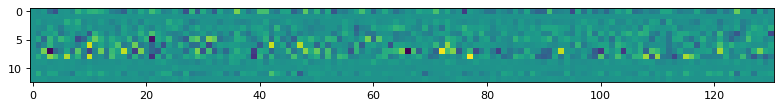

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(et_data[:,::500], interpolation='none')
plt.show()

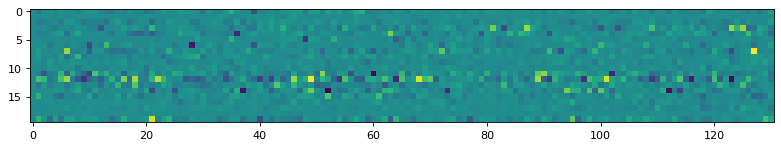

In [8]:
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(parkinson_data[:,::500], interpolation='none')
plt.show()

## Data exploration plots
Let's explore the data a bit more, to see if they correspond to the data in the paper.

#### Parkinson patient data plot

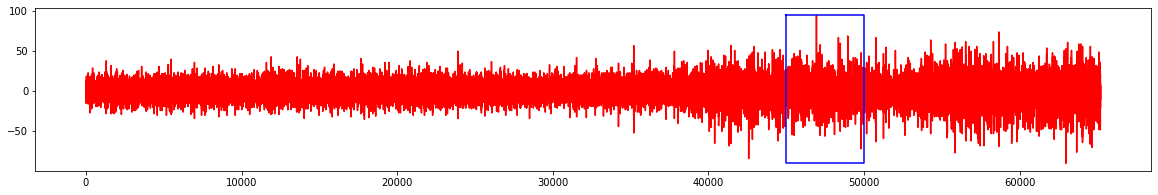

In [34]:
# take a random patient with Parkinson and plot the obtained signal on 10 plots
n = 17 #random.randint(0,20) 
patient_pd = parkinson_data[n,:]
# print(patient_pd.shape)
plt.figure(figsize=(20,3))
plt.plot(patient_pd, 'r')
# plot the zone 
coord = [[45000,95], [50000,95], [50000,-90], [45000,-90]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'
xs, ys = zip(*coord) #create lists of x and y values
plt.plot(xs,ys, 'b') 
plt.show()


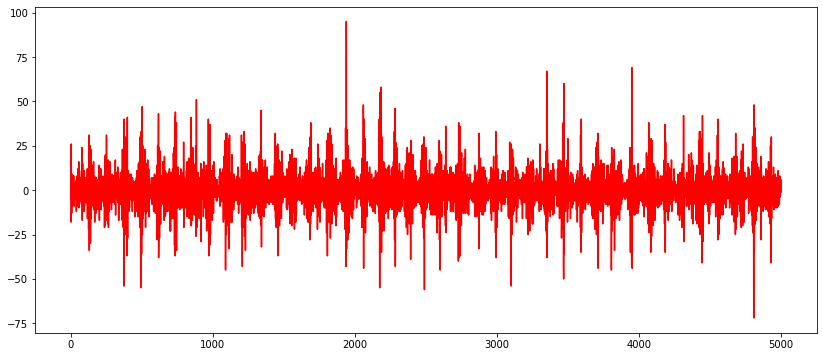

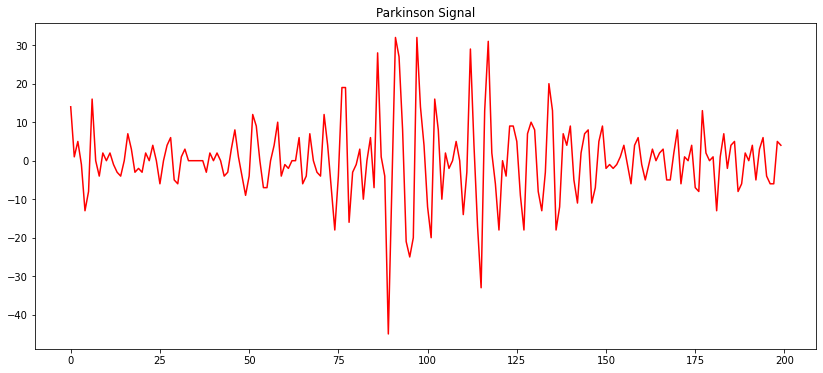

In [35]:
# plot only the selected part of a signal, first 5000
plt.figure(figsize=(14,6))
plt.plot(patient_pd[45000:50000],'r')
plt.show()
# and then just 200 items
plt.figure(figsize=(14,6))
plt.plot(patient_pd[46000:46200],'r')
plt.title('Parkinson Signal')
plt.show()

#### ET patient data plot

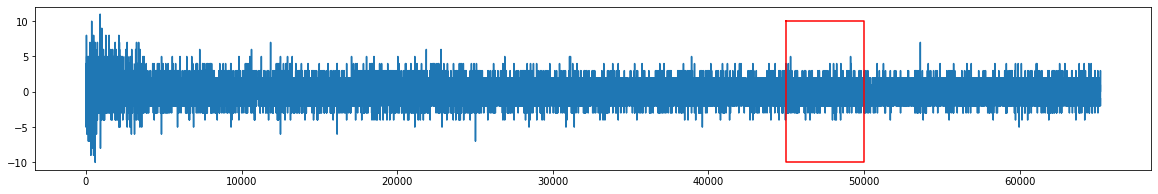

In [32]:
n = 10 #random.randint(0,20) 
patient_et = et_data[n,:]
# print(patient_pd.shape)
plt.figure(figsize=(20,3))
plt.plot(patient_et)
# plot the zone 
coord = [[45000,10], [50000,10], [50000,-10], [45000,-10]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'
xs, ys = zip(*coord) #create lists of x and y values
plt.plot(xs,ys, 'r') 
plt.show()

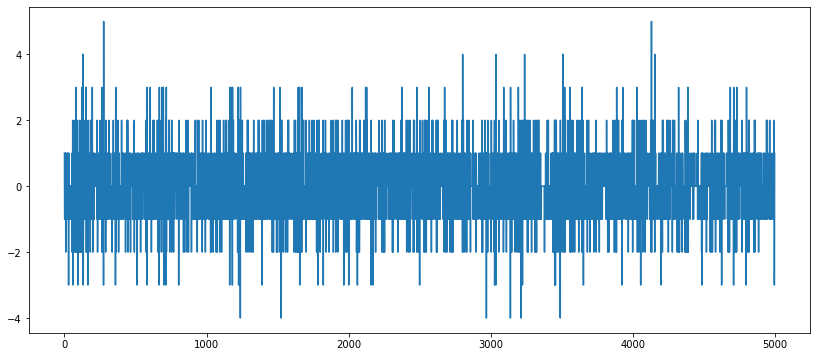

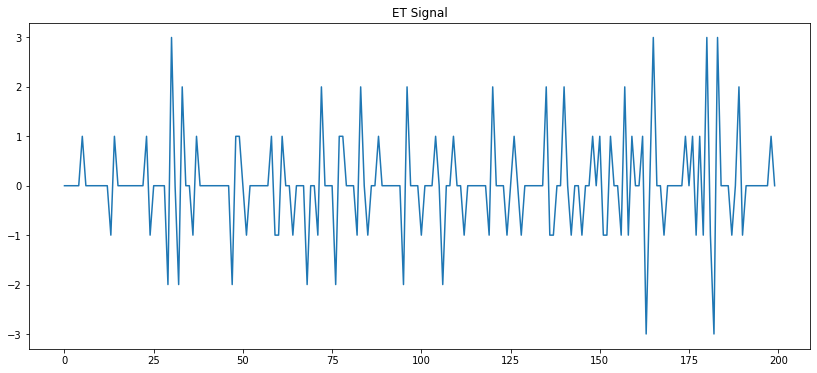

In [36]:
# plot only the selected part of a signal, first 5000
plt.figure(figsize=(14,6))
plt.plot(patient_et[45000:50000])
plt.show()
# and then just 200 items
plt.figure(figsize=(14,6))
plt.plot(patient_et[46000:46200])
plt.title('ET Signal')
plt.show()

Signals look very differently in case of these two patients.
Especially for the amplitute of the signal.
In the paper, the sequence length is 1250 samples. Let's use 5000 window used above to take signal parts.


### Let's now transform the hand data into the 2D features used in the paper.
According to the publication, the features are calculated in  the following way.
Suppose s(n) is a sample of tremor time series, d1 and d2 are delay units
which d1 < d2. 
Let f(n) = (x(n), y(n)) be a two-dimensional signal representing a relation of tremor samples at different delay units d1 and d2 as:

f(n) = (x(n), y(n)) = ((s(n+ d1)-s(n)), (s(n+ d2)-s(n)))

Suppose, for example, time-delay units d1 and d2 are selected to 20 and 40 samples.

In [10]:
# define feature proposed in the paper
def calculate_2D(signal, d1=20, d2=40):
    signal2d = np.zeros((2, len(signal)-d2))
    for i in range(len(signal)-d2):
        signal2d[0,i] = signal[i+d1]-signal[i]
        signal2d[1,i]= signal[i+d2]-signal[i]
    return signal2d

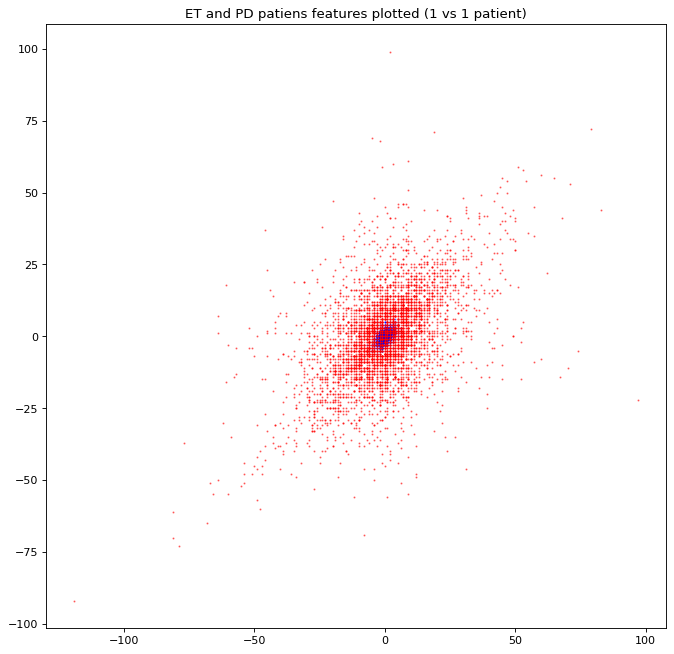

In [41]:
plt.figure(figsize=(10, 10), dpi=80)
transformed_et = calculate_2D(et_data[10])
transformed_pd=calculate_2D(parkinson_data[17])
# take cuts from signal
transformed_et = transformed_et[:,45000:50000]
transformed_pd = transformed_pd[:,45000:50000]
plt.scatter(transformed_et[0], transformed_et[1], c ="blue", alpha=0.5, s=0.7)
plt.scatter(transformed_pd[0], transformed_pd[1], c ="red",alpha=0.5, s=0.7)
# To show the plot
plt.title('ET and PD patiens features plotted (1 vs 1 patient)')
plt.show()

This sample looks rather good, however, if we will select another random pair, it can be different.

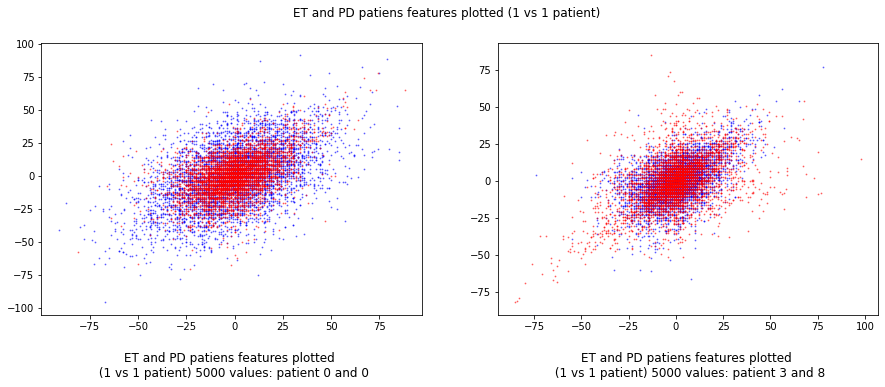

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle('ET and PD patiens features plotted (1 vs 1 patient)')
transformed_et = calculate_2D(et_data[0])
transformed_pd=calculate_2D(parkinson_data[0])
# take cuts from signal
transformed_et = transformed_et[:,45000:50000]
transformed_pd = transformed_pd[:,45000:50000]
ax1.scatter(transformed_et[0], transformed_et[1], c ="blue", alpha=0.5, s=0.7)
ax1.scatter(transformed_pd[0], transformed_pd[1], c ="red",alpha=0.5, s=0.7)
# To show the plot
ax1.set_title('ET and PD patiens features plotted \n (1 vs 1 patient) 5000 values: patient 0 and 0',y=-0.25)
transformed_et = calculate_2D(et_data[3])
transformed_pd=calculate_2D(parkinson_data[8])
# take cuts from signal
transformed_et = transformed_et[:,45000:50000]
transformed_pd = transformed_pd[:,45000:50000]
ax2.scatter(transformed_et[0], transformed_et[1], c ="blue", alpha=0.5, s=0.7)
ax2.scatter(transformed_pd[0], transformed_pd[1], c ="red",alpha=0.5, s=0.7)
# To show the plot
ax2.set_title('ET and PD patiens features plotted \n (1 vs 1 patient) 5000 values: patient 3 and 8',y=-0.25)
plt.show()

This looks already less separable, moreover the ET patient values are much highter, than the PD, which was the case for the selected sample.

Whole data features:

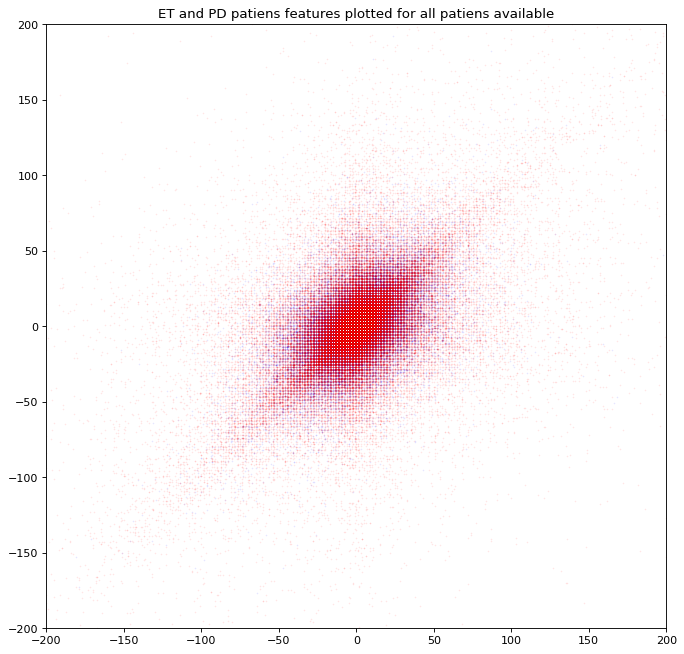

In [40]:
# let's try to get such features for all the data (whole length also), and plot them side by side.
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i])
    plt.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j])
    plt.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
# To show the plot
plt.xlim([-200, 200])
plt.ylim([-200, 200])
# plt.yscale('log')
# plt.xscale('log')
plt.title('ET and PD patiens features plotted for all patiens available')
plt.show()

From the relation between two different unit-delay
versions of tremor signal, we simply draw a 95%
confidence ellipse for each task of individual PD and ET

In [63]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **
    kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

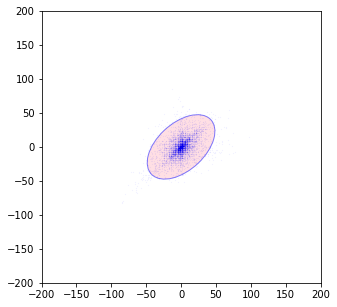

In [63]:
fig, ax_nstd = plt.subplots(figsize=(5, 5))
plt.scatter(transformed_pd[0], transformed_pd[1], c ="blue",alpha=0.2, s=0.01)
confidence_ellipse(transformed_pd[0], transformed_pd[1], ax_nstd, n_std=3,
                   label=r'$1\sigma$', edgecolor='blue',alpha=0.5, facecolor='pink',zorder=0)
plt.xlim([-200, 200])
plt.ylim([-200, 200])
plt.show()

Here is n example of the resulting data,  the confidence interval is equal to 95%.

In [61]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

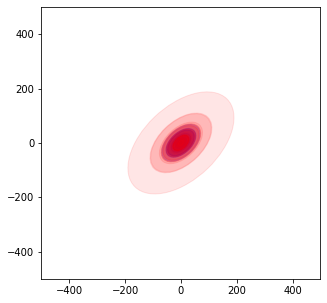

<Figure size 800x800 with 0 Axes>

In [65]:
et_ellipse = []
pd_ellipse = []
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i])
    #ax.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_et[0], transformed_et[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='blue',alpha=0.2, facecolor='blue',zorder=0)
    ax.add_patch(el)
    et_ellipse.append([el.get_center(), el.width, el.height])

for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j])
#     ax.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_pd[0], transformed_pd[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='red',alpha=0.1, facecolor='red',zorder=0)
    ax.add_patch(el)
    pd_ellipse.append([el.get_center(), el.width, el.height])

ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

plt.show()

In [97]:
# we also got ellipses to plot, so let's plot them with a log scale


In [100]:
pd_ellipse

[[(0, 0), 2.43772234969158, 1.434402225951341],
 [(0, 0), 2.5002120493385815, 1.3224748422341237],
 [(0, 0), 2.451800858888737, 1.4102030167151298],
 [(0, 0), 2.4991585946663397, 1.3244645403729636],
 [(0, 0), 2.5085209667371524, 1.3066455370298793],
 [(0, 0), 2.4726668491872688, 1.3732875346883135],
 [(0, 0), 2.5140549390896894, 1.2959659575925362],
 [(0, 0), 2.5172782541108543, 1.289693836296277],
 [(0, 0), 2.4943473402228586, 1.333503410690483],
 [(0, 0), 2.5197242940094435, 1.284908355556384],
 [(0, 0), 2.5166085673710055, 1.2910001234062127],
 [(0, 0), 2.4464349862145918, 1.4194914082956647],
 [(0, 0), 2.440933276220739, 1.4289313283143765],
 [(0, 0), 2.4402615061759865, 1.430078243130671],
 [(0, 0), 2.4687205007904827, 1.3803691857531408],
 [(0, 0), 2.468558878352466, 1.3806581995943872],
 [(0, 0), 2.47559228960821, 1.3680068770413325],
 [(0, 0), 2.488130567130996, 1.3450673889840568],
 [(0, 0), 2.4518174327148756, 1.4101742008118843],
 [(0, 0), 2.5035212102770688, 1.316199661788

In [101]:
et_ellipse

[[(0, 0), 2.444758024169238, 1.4223776584508507],
 [(0, 0), 2.447077828283393, 1.418382918088001],
 [(0, 0), 2.4327124291843787, 1.4428826136910238],
 [(0, 0), 2.432963227110051, 1.4424596824626488],
 [(0, 0), 2.4500950585863577, 1.4131646060847665],
 [(0, 0), 2.4366893721797163, 1.4361562949437017],
 [(0, 0), 2.430056297746177, 1.447351508716574],
 [(0, 0), 2.448346916879663, 1.4161911504475118],
 [(0, 0), 2.441086252330309, 1.4286699789258428],
 [(0, 0), 2.4442284067279383, 1.4232875660751783],
 [(0, 0), 2.450253260128018, 1.4128902863393256],
 [(0, 0), 2.4391377751831604, 1.431994034091812],
 [(0, 0), 2.4467709630373697, 1.4189122081500256]]

# MANUAL SELECTION OF DATA SAMPLES FROM PATIENTS
Previous tests have shown that it is impossible to select a random part of a singal in order to classify PD and ET using the method proposed in the studed paper.
Therefore, we manually select the most characteristic parts from each patient to use them.


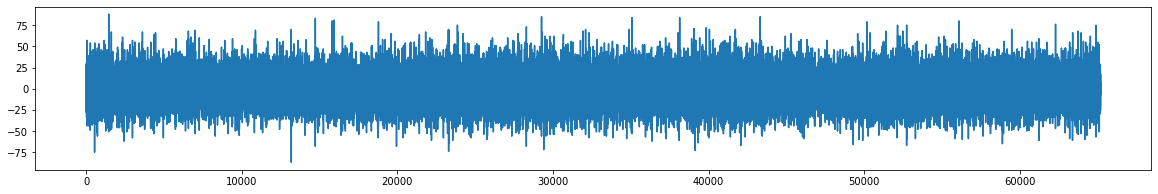

Enter the coordinates of selected signal part (START, END):
10000,20000


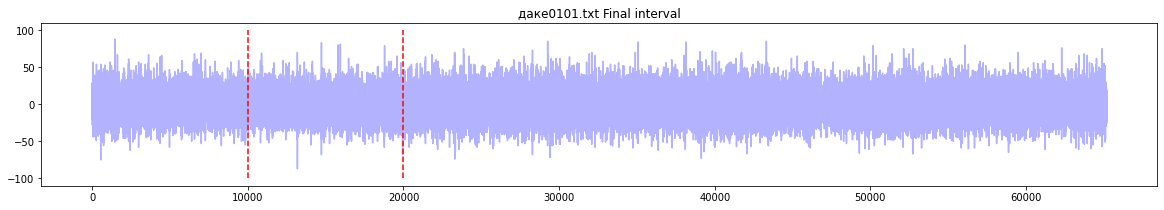

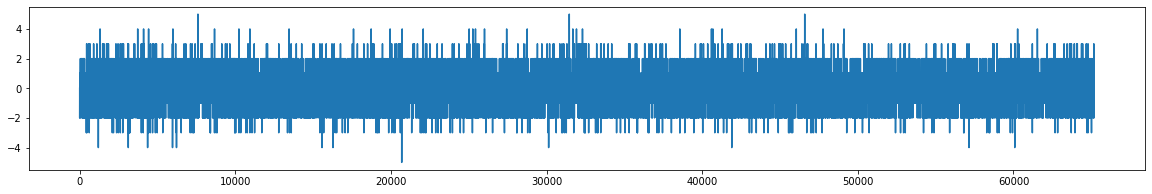

Enter the coordinates of selected signal part (START, END):
20000,30000


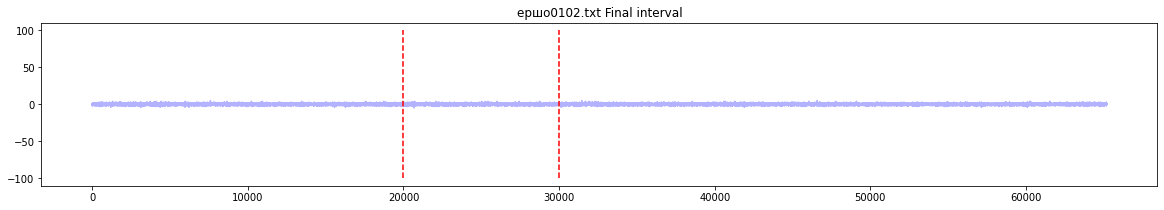

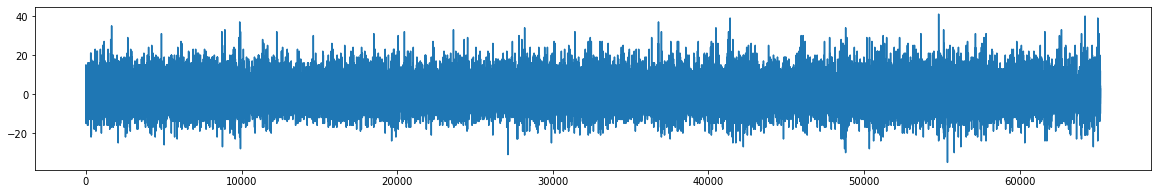

Enter the coordinates of selected signal part (START, END):
10000,20000


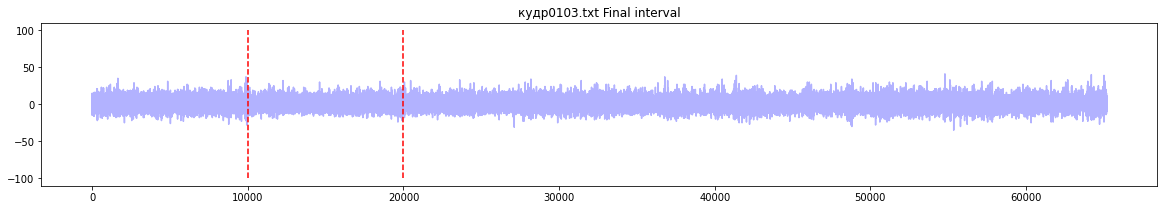

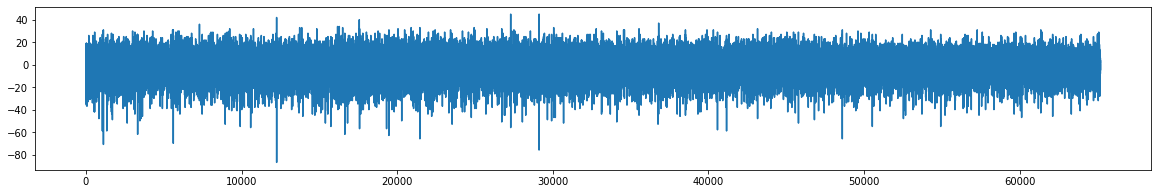

Enter the coordinates of selected signal part (START, END):
30000,40000


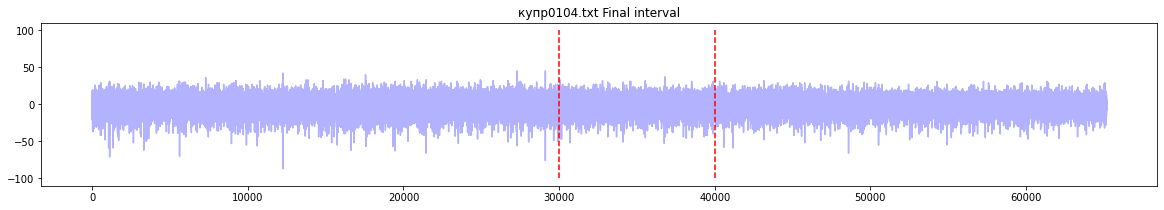

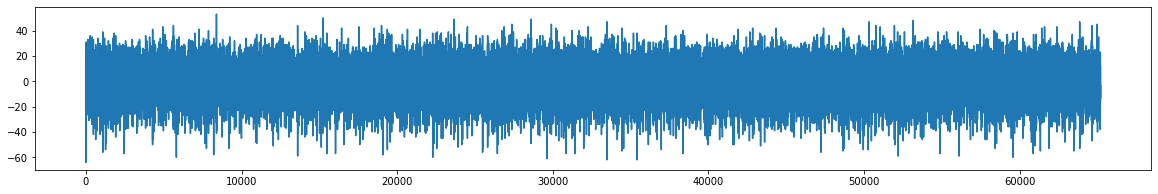

Enter the coordinates of selected signal part (START, END):
10000,20000


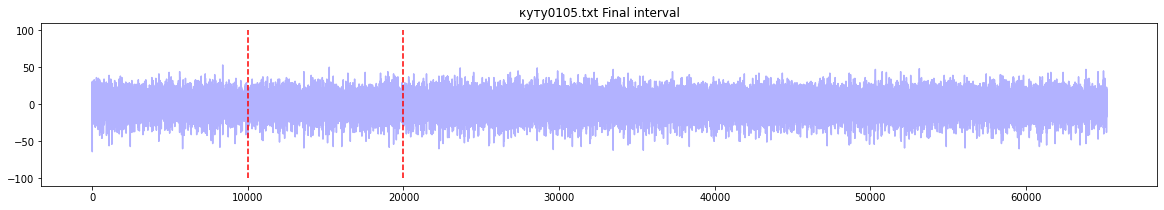

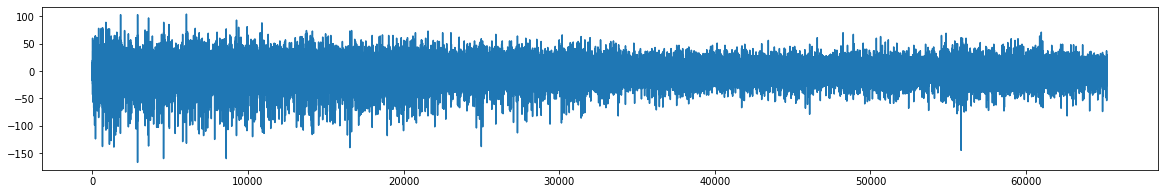

Enter the coordinates of selected signal part (START, END):
40000,50000


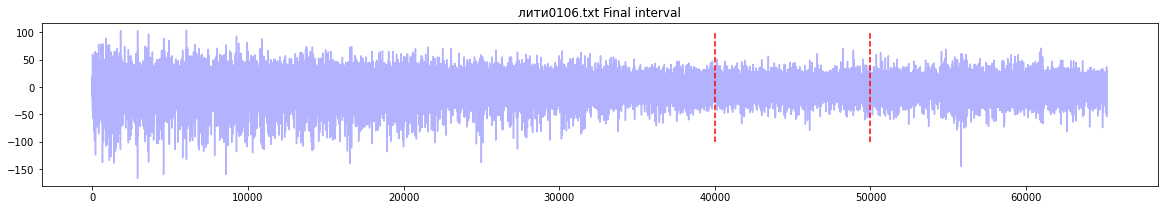

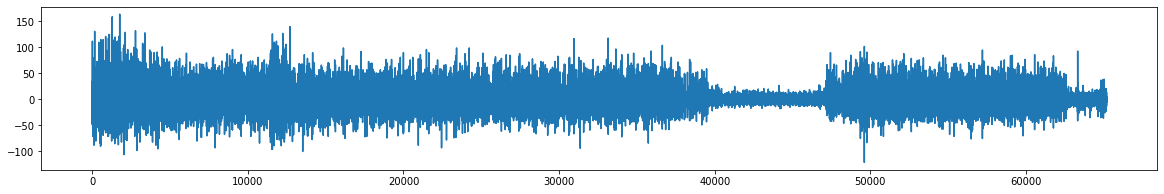

Enter the coordinates of selected signal part (START, END):
20000,30000


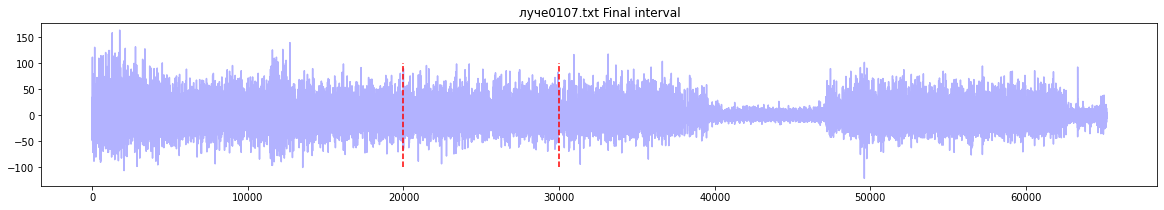

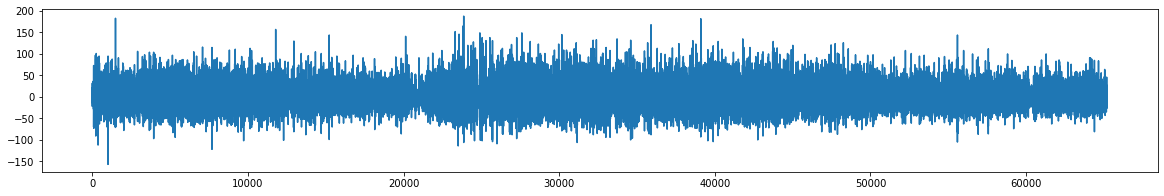

Enter the coordinates of selected signal part (START, END):
30000,40000


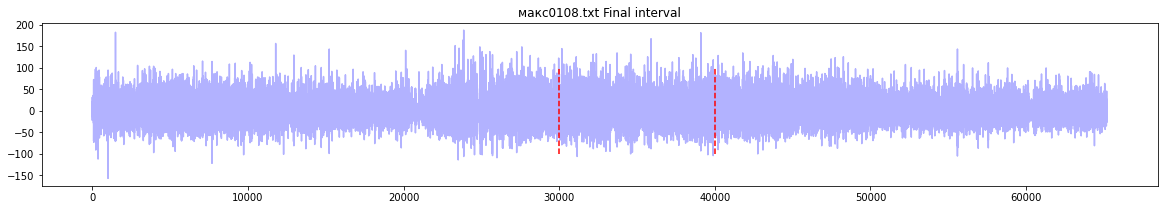

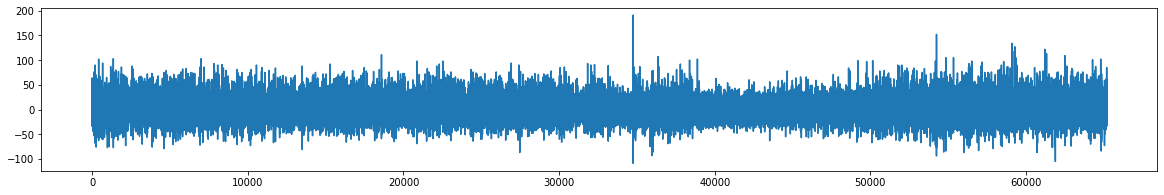

Enter the coordinates of selected signal part (START, END):
10000,20000


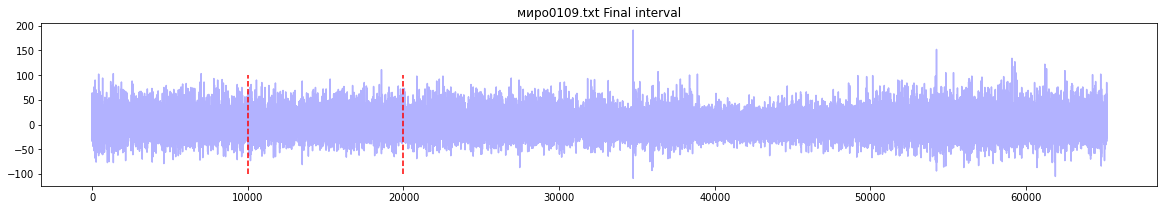

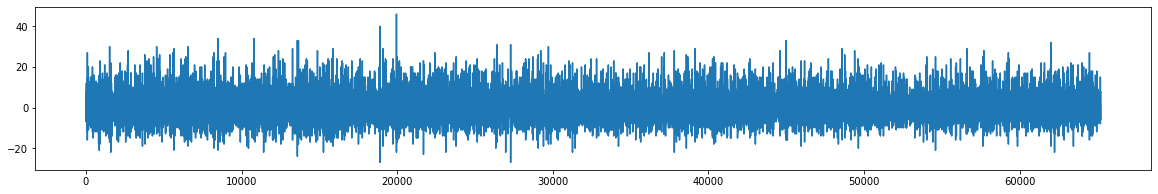

Enter the coordinates of selected signal part (START, END):
10000,20000


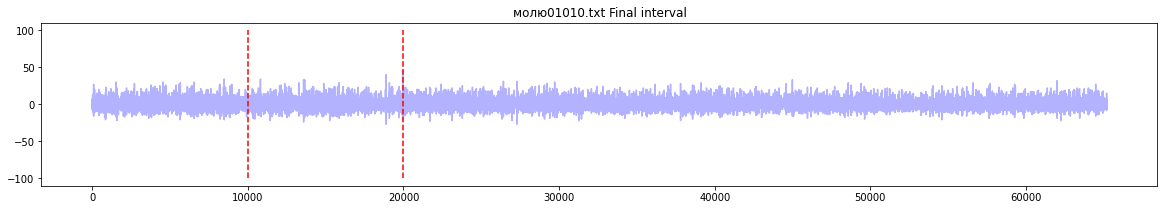

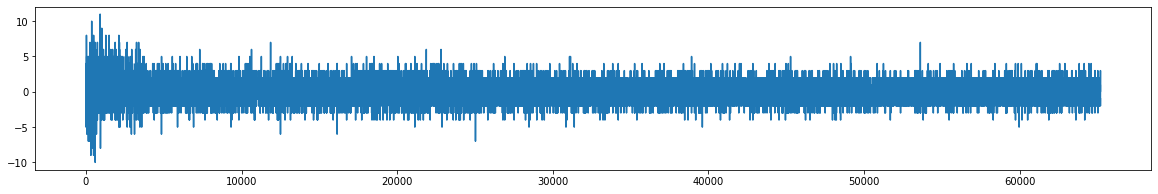

Enter the coordinates of selected signal part (START, END):
20000,30000


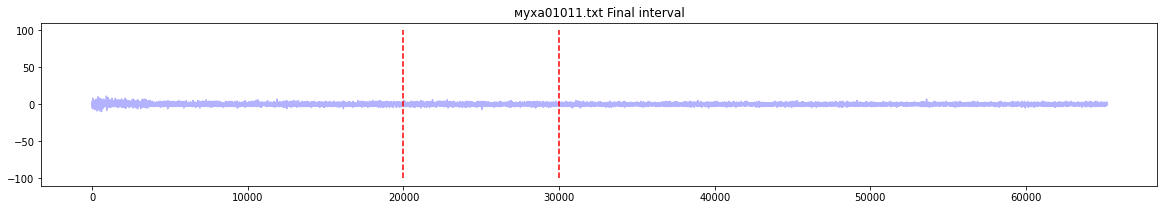

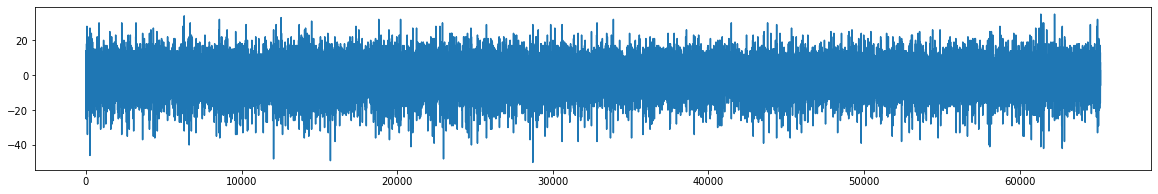

Enter the coordinates of selected signal part (START, END):
10000,20000


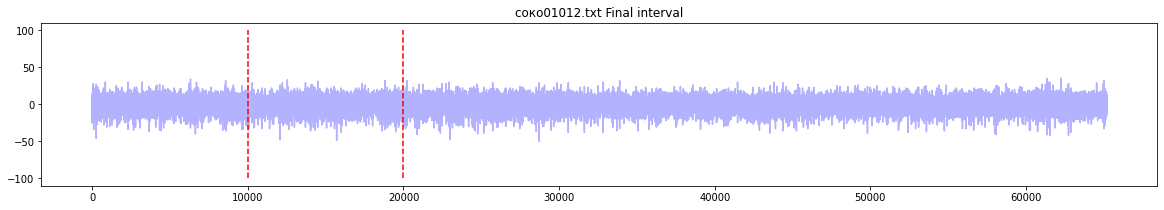

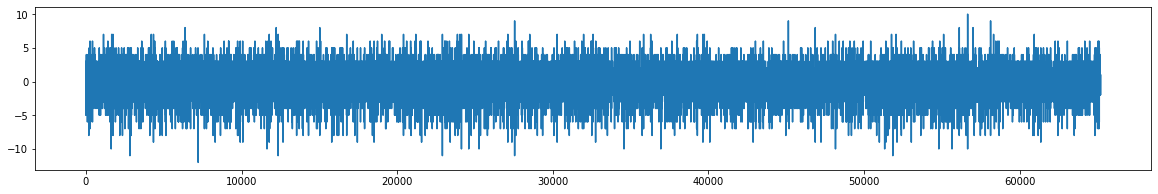

Enter the coordinates of selected signal part (START, END):
10000,20000


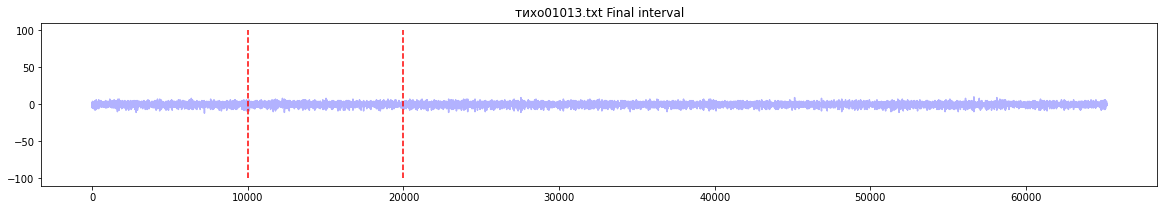

In [52]:
# coordinates_selected_et = np.zeros((len(et_data),2))
for n in range(len(et_data)):
    patient_et = et_data[n,:]
    # print(patient_pd.shape)    
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_et)
    plt.show()
    print('Enter the coordinates of selected signal part (START, END):')
    x = input()
    values = x.split(',')
    coordinates_selected_et[n,0]=int(values[0])
    coordinates_selected_et[n,1]=int(values[1])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_et, 'b', alpha = 0.3)
    ax.vlines([coordinates_selected_et[n,0], coordinates_selected_et[n,1]], -100, 100, linestyles='dashed', colors='red')
    ax.set_title(f"{patients_name_et[n]} Final interval")
    fig.show()
    
    

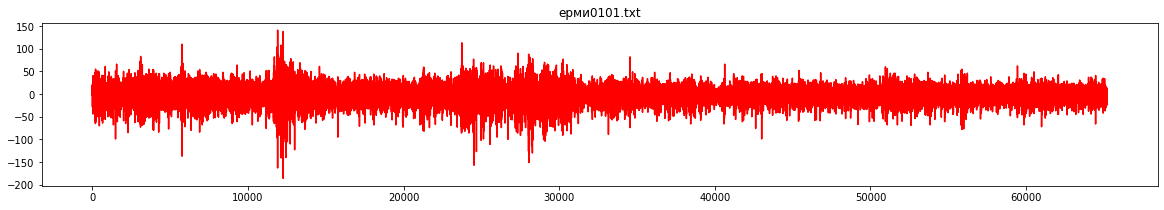

Enter the coordinates of selected signal part (START, END):
20000,30000


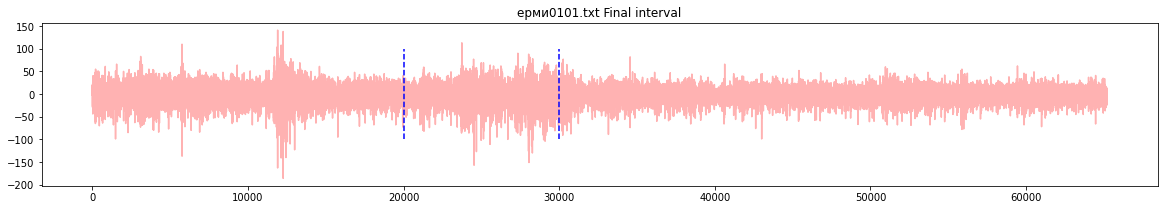

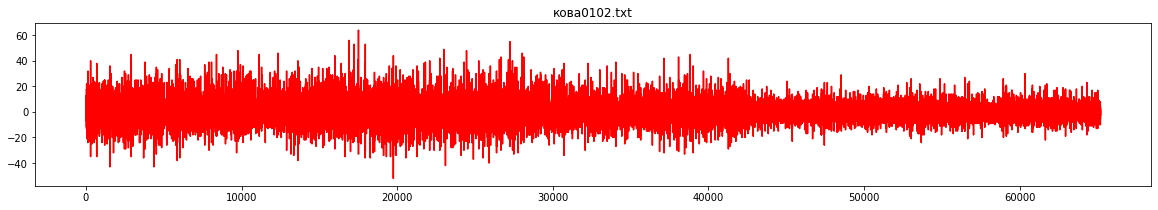

Enter the coordinates of selected signal part (START, END):
10000,20000


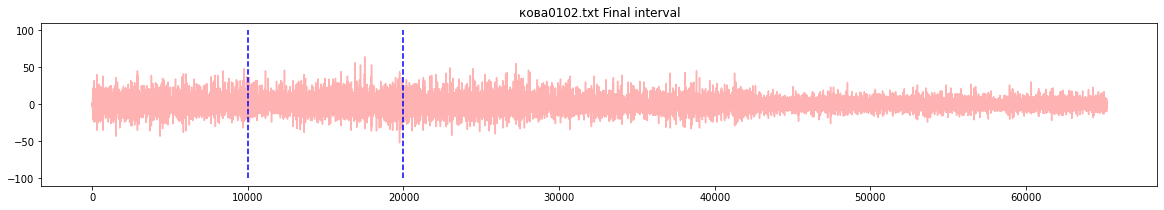

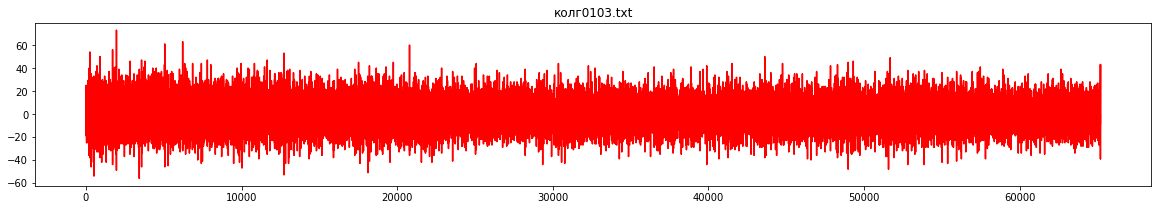

Enter the coordinates of selected signal part (START, END):
10000,20000


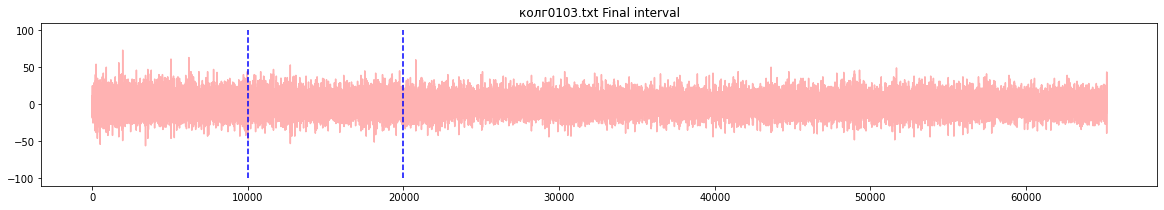

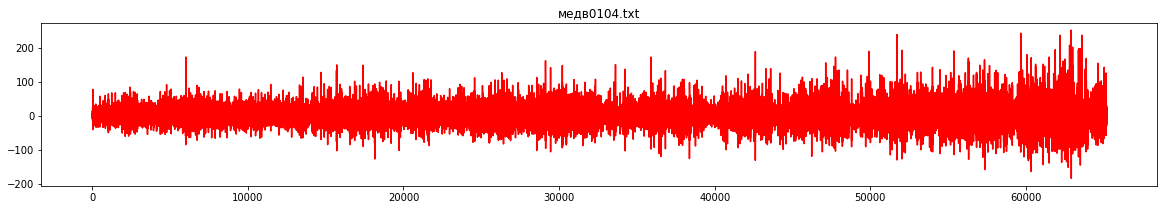

Enter the coordinates of selected signal part (START, END):
20000,30000


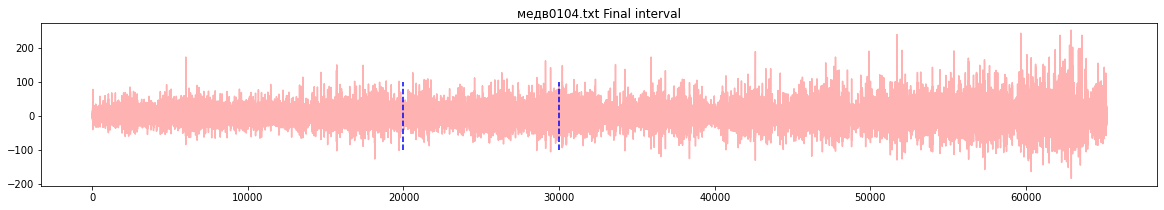

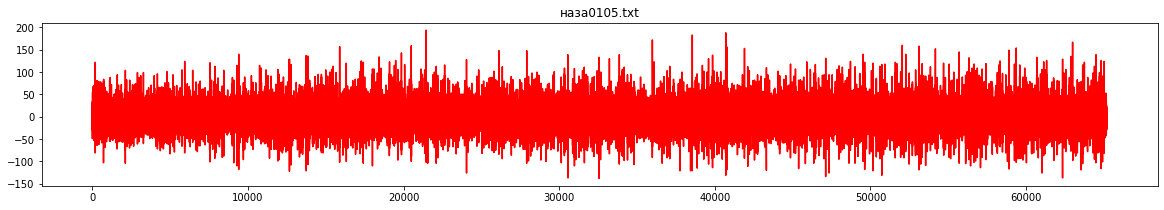

Enter the coordinates of selected signal part (START, END):
30000,40000


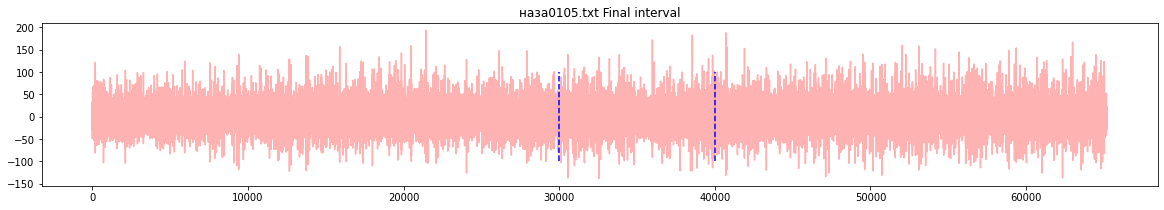

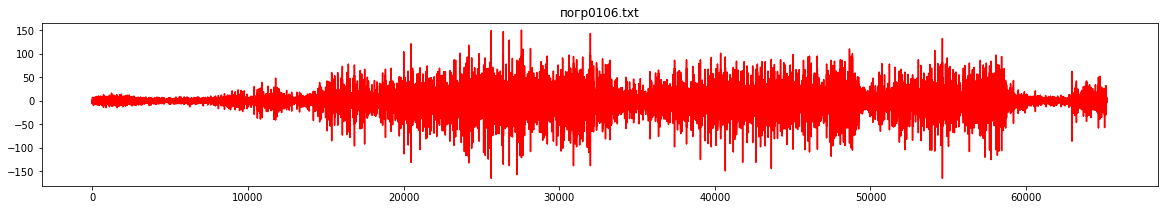

Enter the coordinates of selected signal part (START, END):
20000,30000


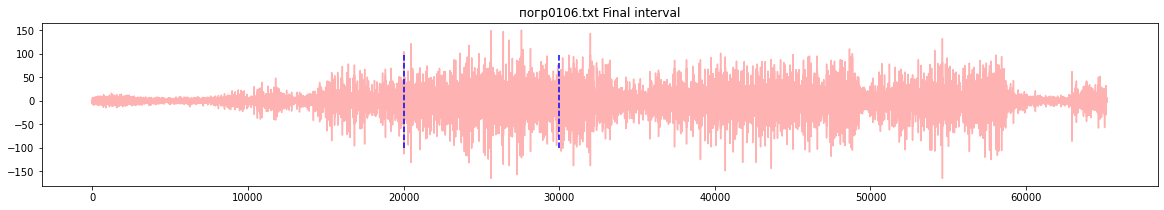

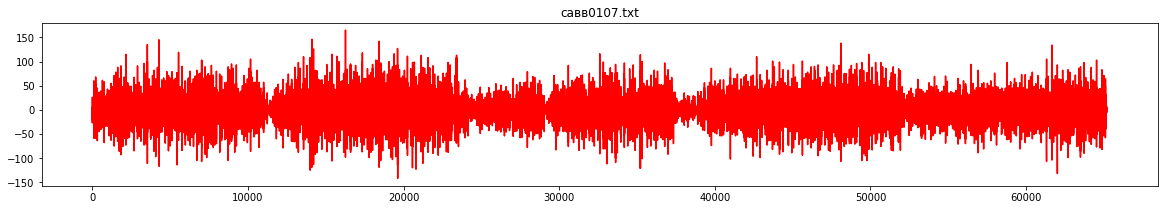

Enter the coordinates of selected signal part (START, END):
10000,20000


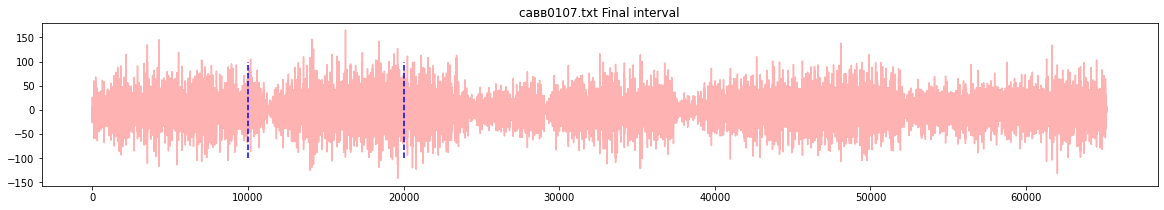

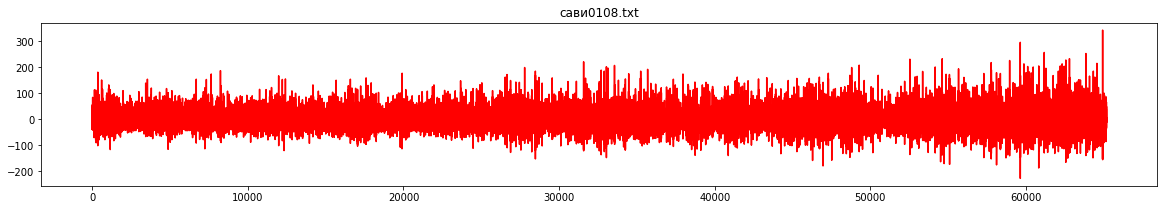

Enter the coordinates of selected signal part (START, END):
20000,30000


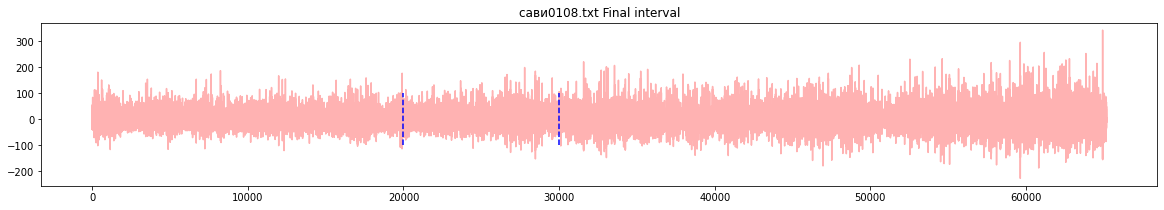

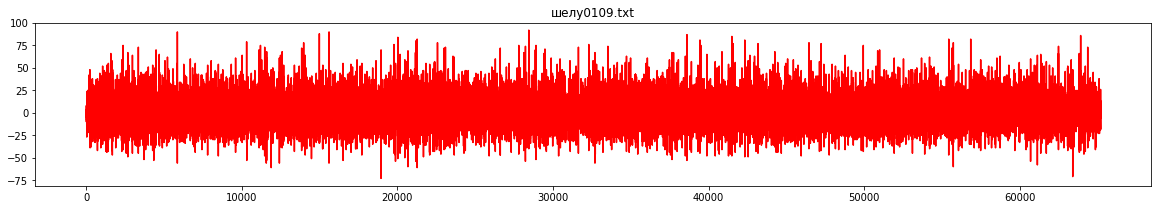

Enter the coordinates of selected signal part (START, END):
20000,30000


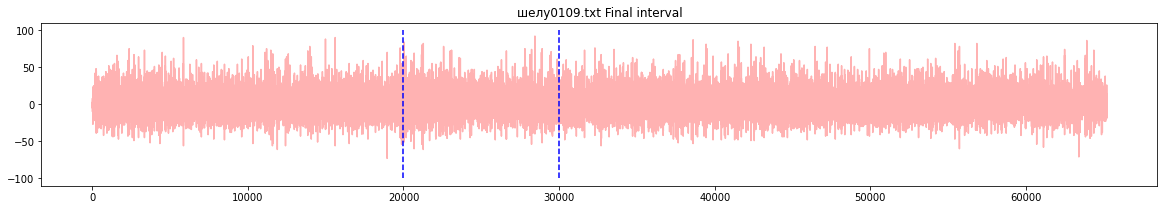

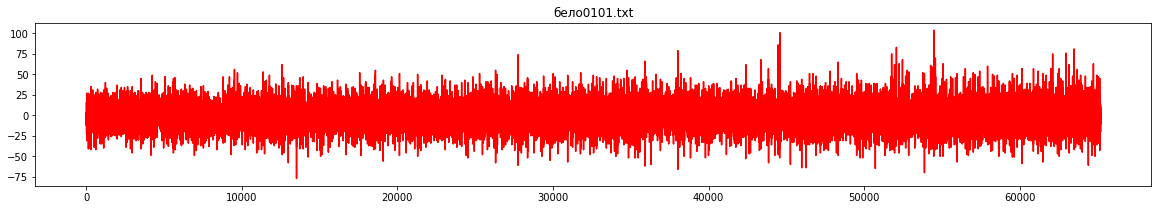

Enter the coordinates of selected signal part (START, END):
20000,30000


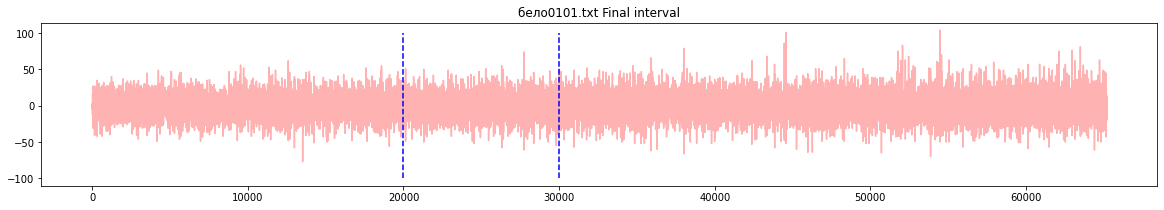

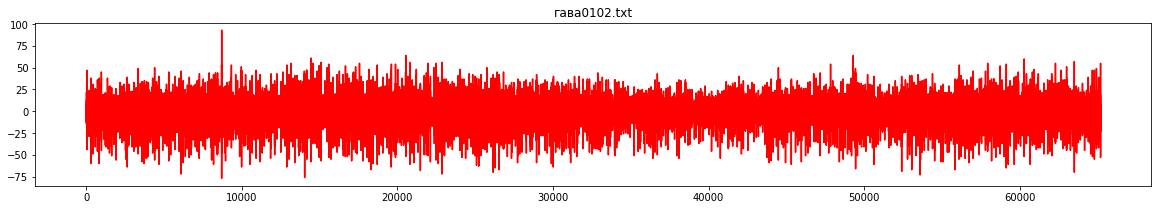

Enter the coordinates of selected signal part (START, END):
20000,30000


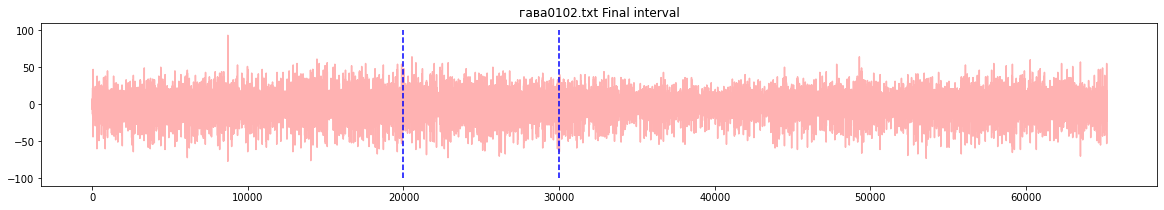

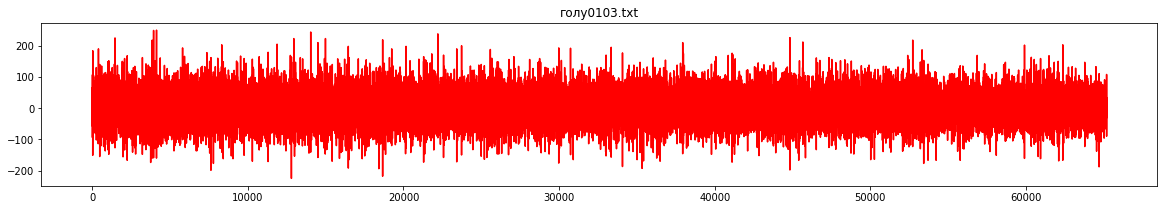

Enter the coordinates of selected signal part (START, END):
20000,30000


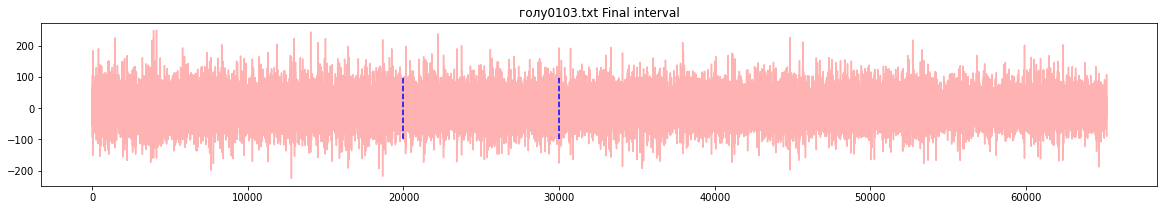

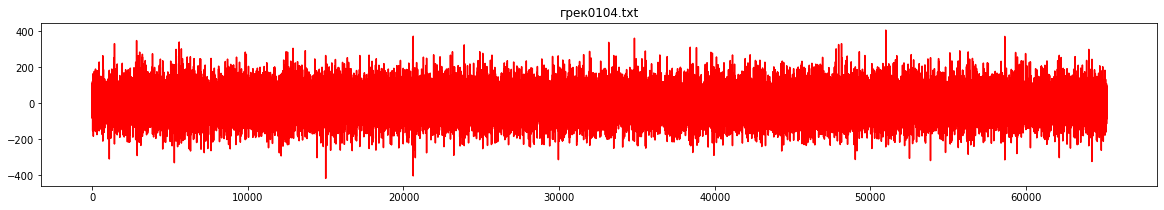

Enter the coordinates of selected signal part (START, END):
10000,20000


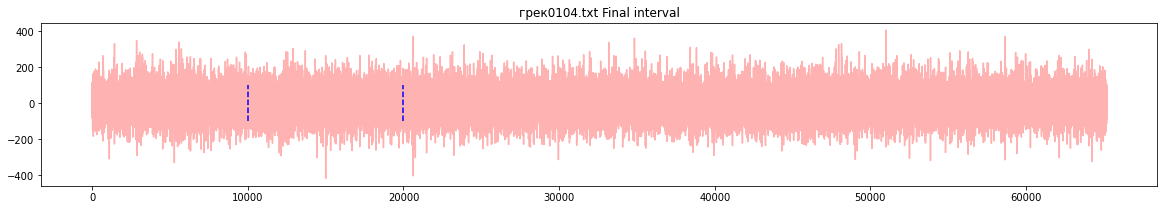

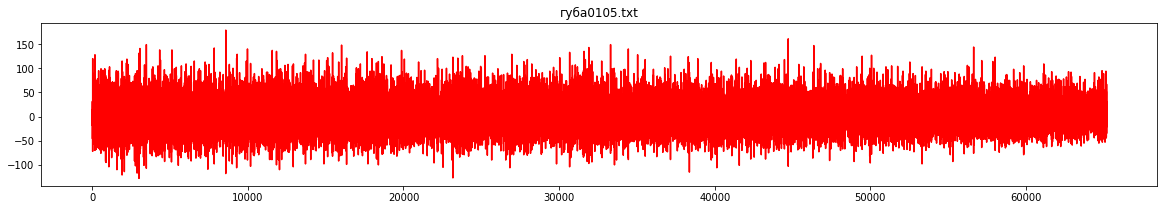

Enter the coordinates of selected signal part (START, END):
10000,20000


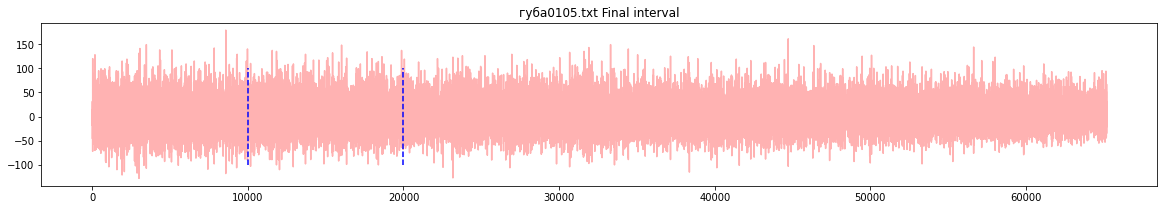

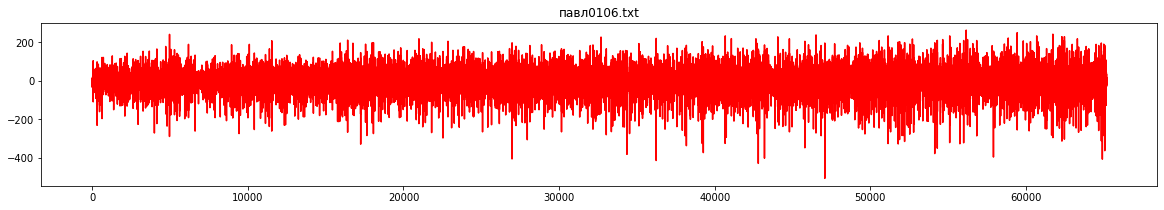

Enter the coordinates of selected signal part (START, END):
40000,50000


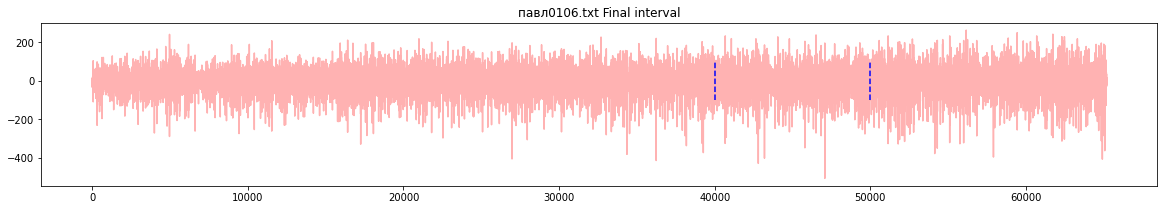

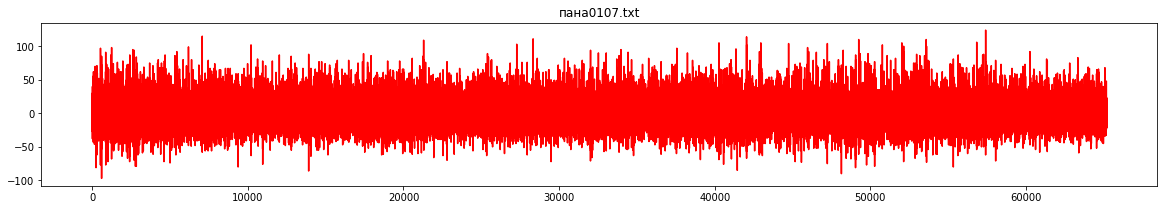

Enter the coordinates of selected signal part (START, END):
10000,20000


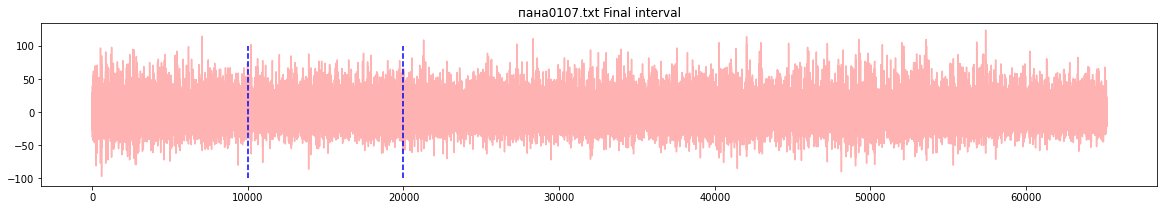

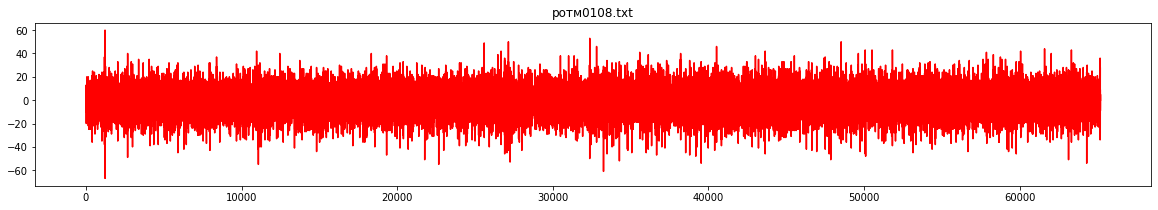

Enter the coordinates of selected signal part (START, END):
10000,20000


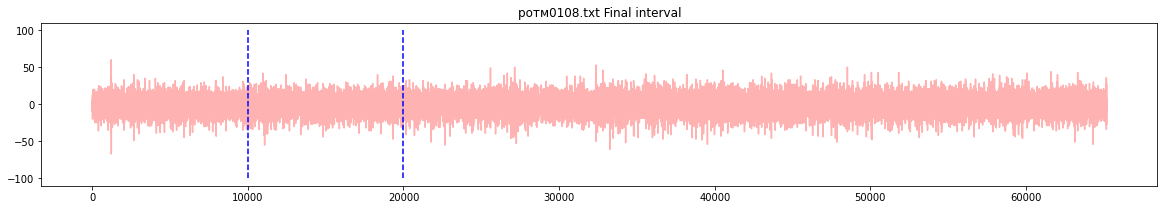

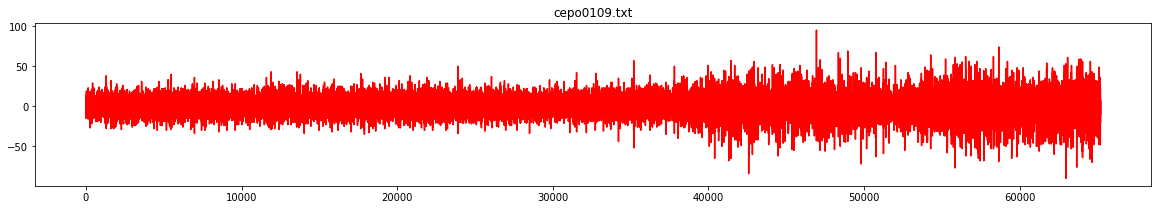

Enter the coordinates of selected signal part (START, END):
40000,50000


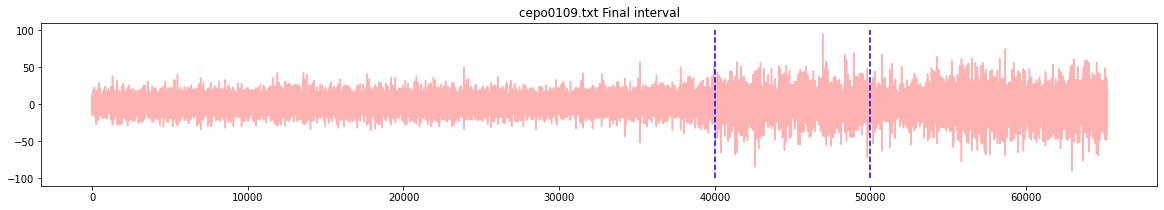

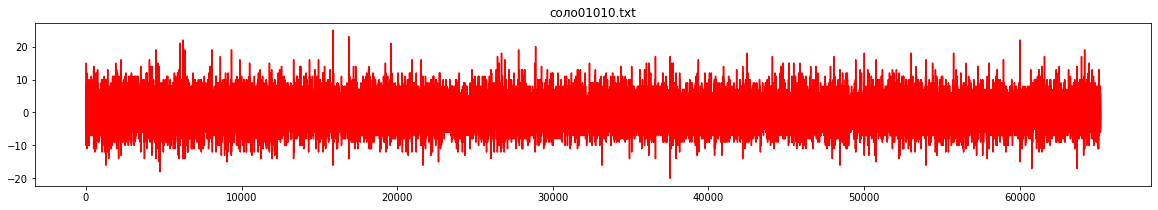

Enter the coordinates of selected signal part (START, END):
30000,40000


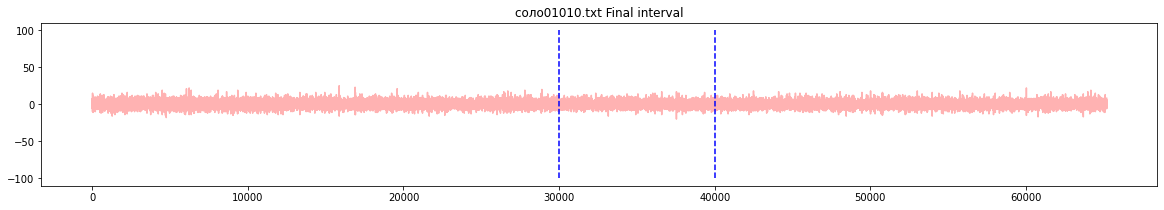

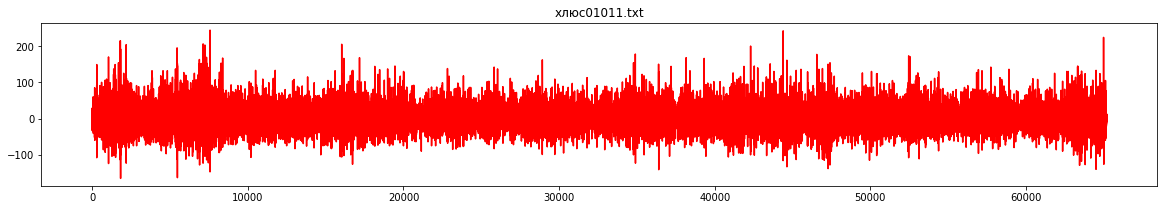

Enter the coordinates of selected signal part (START, END):
40000,50000


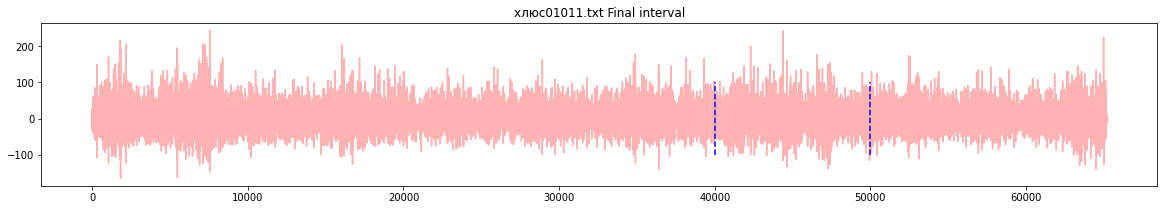

In [50]:
coordinates_selected_pd = np.zeros((len(parkinson_data),2), dtype=int)
for n in range(len(parkinson_data)):
    patient_pd = parkinson_data[n,:]
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_pd, 'r')
    ax.set_title(patients_name_pd[n])
    plt.show()
    print('Enter the coordinates of selected signal part (START, END):')
    x = input()
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_pd, 'r', alpha = 0.3)
    values = x.split(',')
    coordinates_selected_pd[n,0]=int(values[0])
    coordinates_selected_pd[n,1]=int(values[1])
    ax.vlines([coordinates_selected_pd[n,0], coordinates_selected_pd[n,1]], -100, 100, linestyles='dashed', colors='blue')
    ax.set_title(f"{patients_name_pd[n]} Final interval")
    fig.show()

## Test the method on the selected coordinates

In [ ]:
# TODO: dynamic display: https://www.geeksforgeeks.org/how-to-update-a-plot-on-same-figure-during-the-loop/

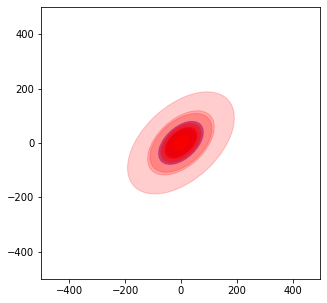

<Figure size 800x800 with 0 Axes>

In [67]:
et_transformed = []
pd_transformed = []
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,int(coordinates_selected_et[i][0]):int(coordinates_selected_et[i][1])])
    #ax.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_et[0], transformed_et[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='blue',alpha=0.2, facecolor='blue',zorder=0)
    ax.add_patch(el)
    et_transformed.append(transformed_et)

for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j,int(coordinates_selected_pd[j][0]):int(coordinates_selected_pd[j][1])])
#     ax.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_pd[0], transformed_pd[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='red',alpha=0.1, facecolor='red',zorder=0)
    ax.add_patch(el)
    pd_transformed.append(transformed_pd)

ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

plt.show()

[ 0.00170683 -0.00301205] [22.90116921 22.76575299]
[0.        0.0001004] [1.10193331 1.07495213]
[-0.00220884 -0.00170683] [8.55510106 8.33986273]
[-0.00140562 -0.00060241] [13.8263905 13.4683028]
[-0.00060241 -0.00110442] [17.41071889 17.07359156]
[0.00130522 0.0003012 ] [19.7818042  19.68684809]
[0.         0.00251004] [23.9692658  23.96398096]
[ 0.         -0.00240964] [40.08626742 39.55828898]
[ 0.00301205 -0.00100402] [26.82404347 26.32639198]
[-0.00070281 -0.00090361] [6.69226757 6.64422169]
[-0.00040161 -0.00060241] [1.51153524 1.46929744]
[ 0.00040161 -0.00110442] [11.11210671 10.88960204]
[0.0002008 0.0001004] [2.24686304 2.2144333 ]


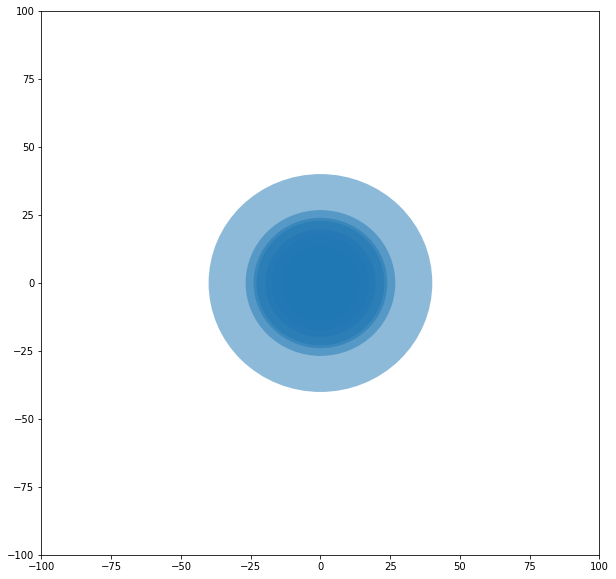

In [91]:
# calculate mu and 2 sigma of each ET
from matplotlib.patches import Circle
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
for e in et_transformed:
    print(np.mean(e,1), np.std(e,1))
    p = Circle(np.mean(e,1), np.std(e,1)[0], alpha=0.5)
    ax.add_patch(p)

[0.         0.00261044] [29.42078398 28.84913662]
[-0.00110442 -0.00080321] [9.86291067 9.75100651]
[-0.00230924  0.00090361] [15.81825412 15.81195659]
[-0.00220884  0.00150602] [28.2696851  28.26259711]
[ 0.00431727 -0.00040161] [33.25655537 32.45250468]
[0.00060241 0.00040161] [26.62699357 26.0857714 ]
[0.00040161 0.        ] [28.81944206 28.67608186]
[0.00251004 0.00793173] [35.70539166 35.46812355]
[0.0001004  0.00140562] [17.41196157 17.19233269]
[-0.00040161 -0.0001004 ] [14.34512217 14.37538545]
[0.00261044 0.00331325] [15.10245443 14.76673678]
[-0.00883534  0.01034137] [55.51084885 54.07401585]
[0.00040161 0.00421687] [95.65069273 93.90373597]
[ 0.00251004 -0.00190763] [38.2054383  38.12464361]
[-0.00271084 -0.00773092] [59.76030177 59.13764864]
[-0.00040161  0.00210843] [25.88784118 25.5022933 ]
[ 0.0003012 -0.0002008] [12.3154285  12.07659624]
[ 0.00070281 -0.00090361] [15.71157899 15.61339205]
[-0.00110442 -0.00120482] [4.54958169 4.44104606]
[0.00361446 0.00090361] [35.7852

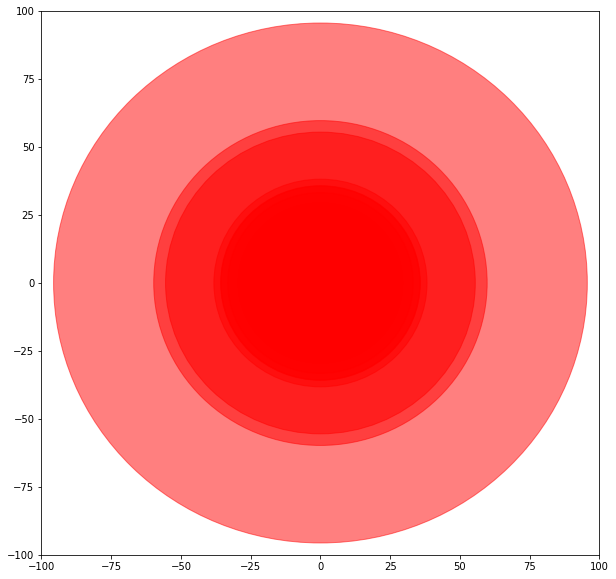

In [92]:
# calculate mu and 2 sigma of each ET
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
for e in pd_transformed:
    print(np.mean(e,1), np.std(e,1))
    p = Circle(np.mean(e,1), np.std(e,1)[0], alpha=0.5, color='r')
    ax.add_patch(p)

# Implement SVM on the given features (mu and sigma)

To simplify a bit, I take not the area of an ellipse, as proposed by the authors, but the area of a circle with 2 std, which means that the formula I use is:

feature = Pi (2sigma)^2

It means that in the end we can just compare 2 sigmas values, which I do in the following.

In [98]:
et_feature=np.zeros((len(et_transformed),2))
for i, e in enumerate(et_transformed):
    et_feature[i,:]=np.std(e,1)*2 


Text(0.5, 1.0, '2 variances box plots for ET patients')

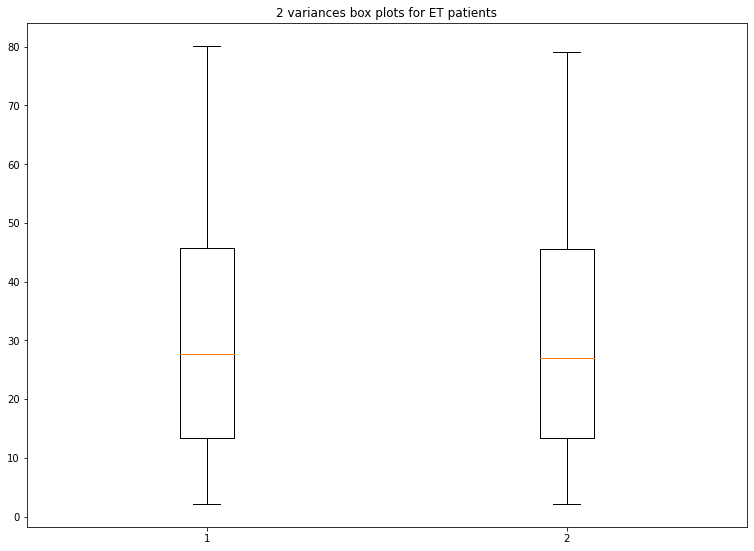

In [101]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(et_feature)
ax.set_title('2 variances box plots for ET patients')

In [103]:
pd_feature=np.zeros((len(pd_transformed),2))
for i, e in enumerate(pd_transformed):
    pd_feature[i,:]=np.std(e,1)*2 


Text(0.5, 1.0, '2 variances box plots for PD patients')

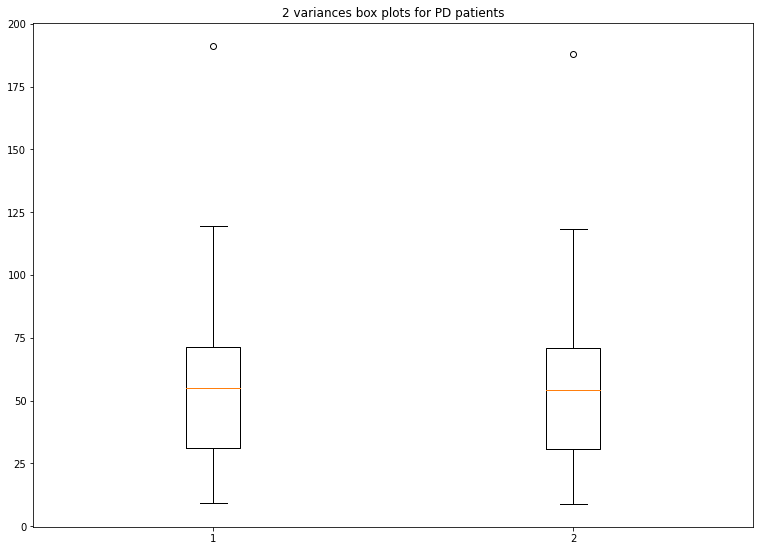

In [104]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(pd_feature)
ax.set_title('2 variances box plots for PD patients')

Text(0.5, 1.0, '2 variances box plots for PD patients')

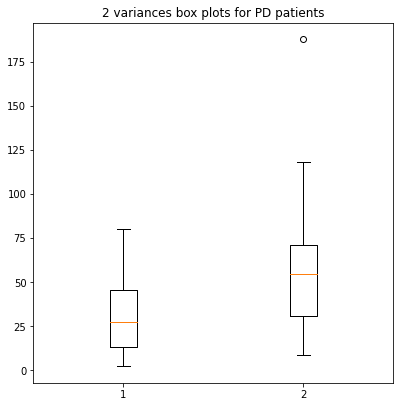

In [109]:
# plot side by side ET and PD
fig = plt.figure(figsize =(5,5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot([et_feature[:,0], pd_feature[:,1]])
ax.set_title('2 variances box plots for PD patients')

## Histograms of the obtained features
Let's plot histograms for the patients with Parkinson and Tremor to see if they are separable.


2D histograms on the extracted features

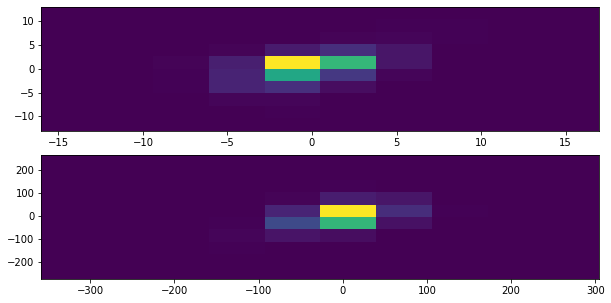

In [13]:
fig, axs = plt.subplots(2, 1, figsize = (10,5))
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,:]) # back to whole data
    axs[0].hist2d(transformed_et[0],transformed_et[1])
for i in range(len(parkinson_data)):
    transformed_pd = calculate_2D(parkinson_data[i,:]) # back to whole data
    axs[1].hist2d(transformed_pd[0],transformed_pd[1])

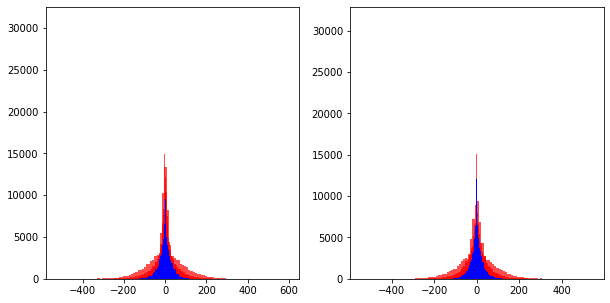

In [22]:
# 2 1D histograms : feature 1 and feature 2
fig, axs = plt.subplots(1,2, figsize = (10,5))
for i in range(len(parkinson_data)):
    transformed_pd = calculate_2D(parkinson_data[i,:]) # back to whole data
    axs[0].hist(transformed_pd[0], bins = 100, color= 'r', alpha = 0.7)
    axs[1].hist(transformed_pd[1], bins = 100, color= 'r', alpha = 0.7)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,:]) # back to whole data
    axs[0].hist(transformed_et[0], bins = 100, color= 'b')
    axs[1].hist(transformed_et[1], bins = 100, color= 'b')

(array([4., 6., 2., 5., 0., 2., 0., 0., 0., 1.]),
 array([  9.46460492,  27.41662935,  45.36865378,  63.32067821,
         81.27270264,  99.22472707, 117.1767515 , 135.12877593,
        153.08080036, 171.03282479, 188.98484922]),
 <BarContainer object of 10 artists>)

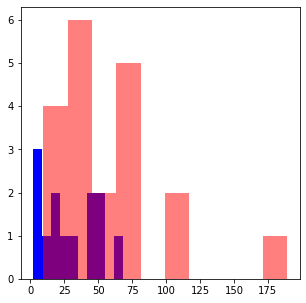

<Figure size 800x800 with 0 Axes>

In [45]:
### If we will plot the histogrmas of the variability directly
et_transformed_std = np.zeros((len(et_data),2))
pd_transformed_std = np.zeros((len(parkinson_data),2))
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,:])
   # get the std for transformed data
    std = np.std(transformed_et,1)
    et_transformed_std[i,:]=std[0],std[1]
for i in range(len(parkinson_data)):
    transformed_pd = calculate_2D(parkinson_data[i,:]) # back to whole data
    std = np.std(transformed_pd,1)
    pd_transformed_std[i,:]=std[0],std[1]
ax.hist(et_transformed_std[:,1]+et_transformed_std[:,0], bins =10, color ='b')
ax.hist(pd_transformed_std[:,1]+pd_transformed_std[:,0], bins = 10,color ='r', alpha = 0.5)

In [46]:
#TODO: Plot for signal parts, but we already know that it won't work as well

# Conclusion:
It is impossible to seprate the patients using the proposed feature with the parameters, proposed in the paper.

In [37]:
et_transformed_std.shape

(13, 2)

In [42]:
et_transformed_std[:,1]+et_transformed_std[:,0]

array([47.92173612,  2.16989595, 18.21423642, 27.87932176, 35.01836612,
       52.38305345, 47.13236414, 68.06494446, 53.60980473, 12.17583356,
        2.94523733, 20.58468444,  4.35107513])